In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare
from aeon.visualisation import plot_critical_difference

color = sns.color_palette('dark')[1]

# This nb is an adaptation of the code written by Milena Monteiro
# Available at: https://dev.to/milenamonteiro/comparing-machine-learning-algorithms-using-friedman-test-and-critical-difference-diagrams-in-python-10a9 
# Acessed in 22/10/2025

In [32]:
def cd_graph(data, name): 
    # Convert the data into a DataFrame
    datasets = data['Datasets']
    algorithms = data['Algorithms']
    performance_data = data['Performance (Macro-F1)']
    
    # Create a list of dictionaries for each dataset
    rows = []
    for dataset, performance in zip(datasets, performance_data):
        row = {'Dataset': dataset}
        row.update({alg: perf for alg, perf in zip(algorithms, performance)})
        rows.append(row)
    
    # Create the DataFrame
    df = pd.DataFrame(rows)
    
    # Convert string percentages to floats
    for alg in algorithms:
        df[alg] = df[alg].str.replace(',', '.').str.rstrip('%').astype(float) / 100
    
    # Calculate the ranking of each algorithm for each dataset
    rankings_matrix = df[algorithms].rank(axis=1, method='min', ascending=True)
    
    # Format the results
    formatted_results = df[algorithms].copy()
    for col in formatted_results.columns:
        formatted_results[col] = formatted_results[col].round(3).astype(str) + " (" + rankings_matrix[col].astype(int).astype(str) + ")"
    
    # Add a row for the sum of ranks and average of ranks
    sum_ranks = rankings_matrix.sum().round(3).rename('Sum Ranks')
    average_ranks = rankings_matrix.mean().round(3).rename('Average Ranks')
    
    # Add the rows to the formatted DataFrame using concat
    formatted_results = pd.concat([formatted_results, sum_ranks.to_frame().T, average_ranks.to_frame().T])
    
    # Add the 'Dataset' column to the formatted DataFrame
    formatted_results.insert(0, 'Dataset', df['Dataset'].tolist() + ['Sum Ranks', 'Average Ranks'])
    
    # Display the table
    print("Error Table (%) with Ranking:")
    print(formatted_results)
    
    # Save the formatted table as an image
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=formatted_results.values, colLabels=formatted_results.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(2.5, 2.5)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=1, wspace=0.2, hspace=0.2)
    plt.savefig('table_with_rankings.png', format="png", bbox_inches="tight", dpi=300)
    plt.show()
    
    print("Table saved as 'table_with_rankings.png'")
    
    # Perform the Friedman Test
    friedman_stat, p_value = friedmanchisquare(*rankings_matrix.T.values)
    print(f"Friedman test statistic: {friedman_stat}, p-value = {p_value}")
    
    # Convert the accuracy matrix into a NumPy array for the critical difference diagram
    scores = df[algorithms].values
    classifiers = df[algorithms].columns.tolist()
    
    print("Algorithms:", classifiers)
    print("Errors:", scores)
    
    # Set the figure size before plotting
    plt.figure(figsize=(14, 12))  # Adjust the figure size as needed
    
    # Generate the critical difference diagram
    plot_critical_difference(
        scores, 
        classifiers, 
        lower_better=True,
        test='wilcoxon',  # or nemenyi
        correction='holm', # or bonferroni or none
    )
    
    # Get the current axes
    ax = plt.gca()
    
    # Get all horizontal lines (y1 == y2)
    horizontal_lines = [line for line in ax.lines if line.get_ydata()[0] == line.get_ydata()[1]]
    
    # Sort by line length (axis line is usually the longest)
    horizontal_lines = sorted(horizontal_lines, key=lambda l: abs(l.get_xdata()[1] - l.get_xdata()[0]), reverse=True)
    
    # First one is usually the axis; the rest are similarity bars
    if len(horizontal_lines) > 1:
        for line in horizontal_lines[1:]:
            line.set_color(color)  # color for similar groups
            line.set_linewidth(3)
            line.set_alpha(0.9)
    
    # Adjust font size and rotation of x-axis labels
    for label in ax.get_xticklabels():
        label.set_fontsize(5) 
        label.set_rotation(45) 
        label.set_horizontalalignment('right')
    
    # Increase padding between labels and axis
    ax.tick_params(axis='x', which='major', pad=10)
    
    # Adjust margins to provide more space for labels
    plt.subplots_adjust(bottom=0.35)
    
    # Optionally adjust y-axis label font size
    ax.tick_params(axis='y', labelsize=10)
    
    # Save and display the plot
    plt.savefig(f'critical_difference_diagram_{name}.pdf', format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

Error Table (%) with Ranking:
                              Dataset     IH + U     IF + U   Standard
0              hospitalization_dengue  0.012 (1)  0.013 (3)  0.013 (2)
1                   authorization_sus  0.013 (1)  0.016 (2)  0.016 (3)
2                            severity  0.015 (2)  0.013 (1)  0.016 (3)
3                               lymph  0.011 (1)  0.015 (3)  0.014 (2)
4                               heart  0.007 (1)  0.008 (2)  0.018 (3)
5                        beioresponse  0.011 (1)  0.011 (2)  0.011 (2)
Sum Ranks                   Sum Ranks        7.0       13.0       15.0
Average Ranks           Average Ranks      1.167      2.167        2.5


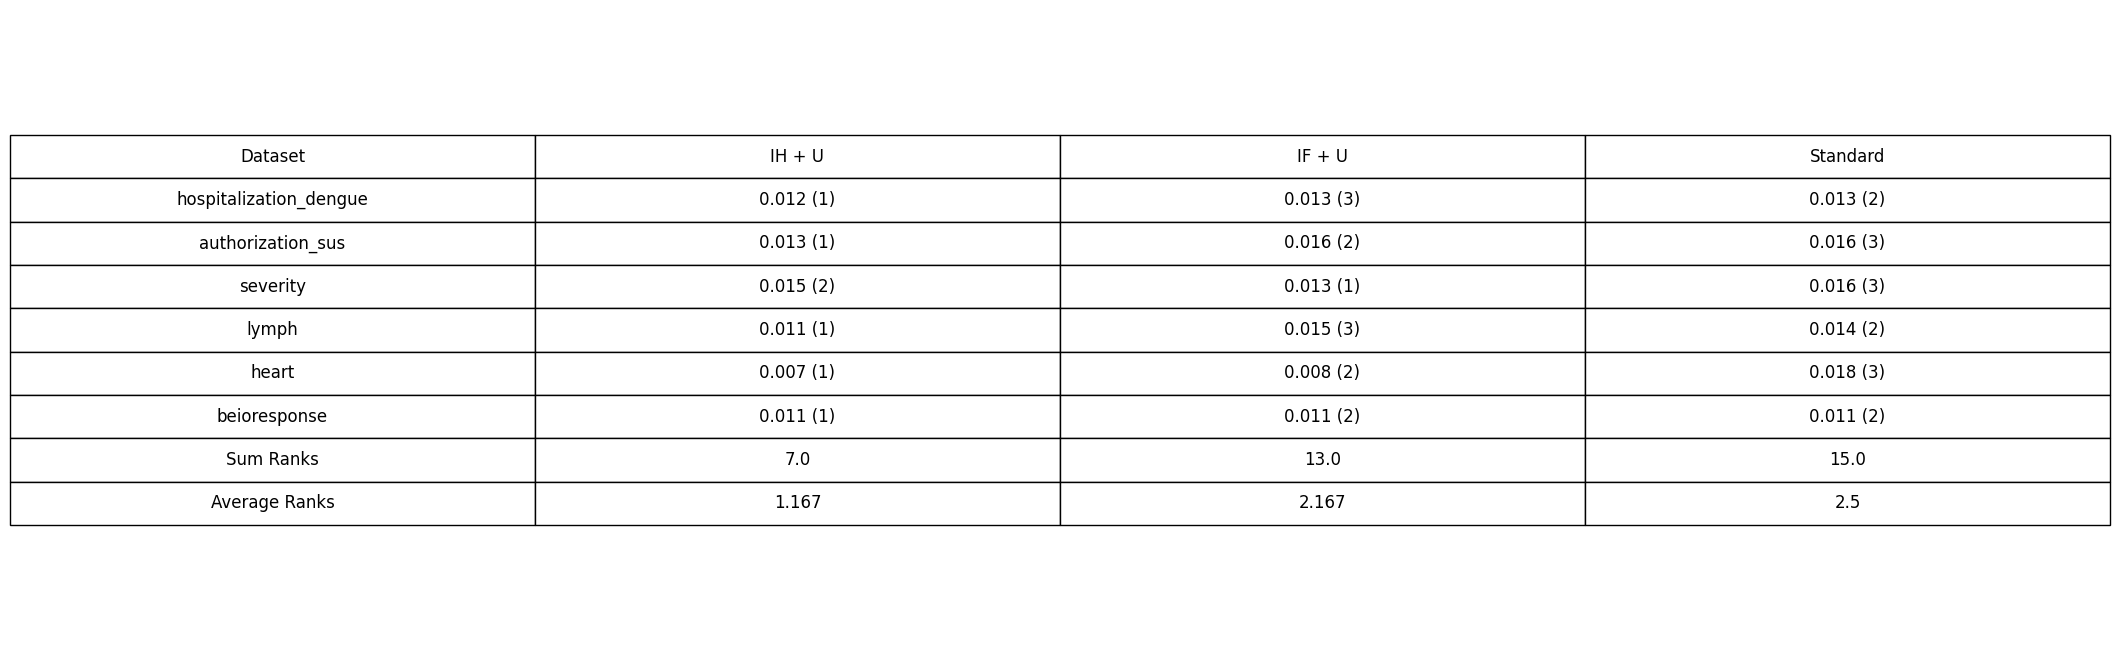

Table saved as 'table_with_rankings.png'
Friedman test statistic: 6.869565217391299, p-value = 0.03223241651740552
Algorithms: ['IH + U', 'IF + U', 'Standard']
Errors: [[0.0125  0.0133  0.0132 ]
 [0.0126  0.0157  0.0163 ]
 [0.0153  0.0133  0.0161 ]
 [0.0106  0.0147  0.0141 ]
 [0.00691 0.00801 0.0176 ]
 [0.0109  0.0111  0.0111 ]]


<Figure size 1400x1200 with 0 Axes>

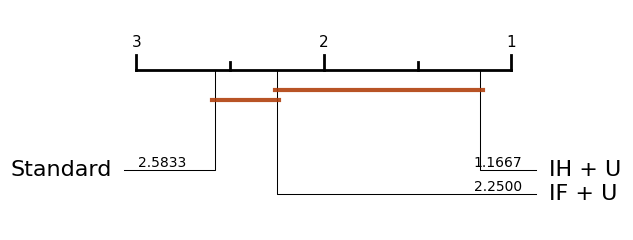

In [36]:
data_uncertainty = {
    'Datasets': [
      'hospitalization_dengue', 'authorization_sus', 
      'severity', 'lymph',
      'heart', 'beioresponse'
    ],
    'Algorithms': [
        'IH + U', 'IF + U', 'Standard'
    ],
    'Performance (Macro-F1)': [
        [ # hospitalization_dengue
            '1.25', '1.33', '1.32'
        ],
        [ # authorization_sus
            '1.26','1.57','1.63'  
        ],
        [ # severity
            '1.53','1.33','1.61'
        ],
        [ # limphy
            '1.06', '1.47', '1.41'
        ],
        [  # heart
            '0.691','0.801','1.76'
        ],
        [ # bioresponse
            '1.09','1.11','1.11'
        ]
    ]
}

cd_graph(data_uncertainty, 'uncertainty')

Error Table (%) with Ranking:
                              Dataset     IH + C     IF + C   Standard
0              hospitalization_dengue  0.009 (1)   0.01 (2)  0.011 (3)
1                   authorization_sus  0.013 (1)  0.014 (2)  0.015 (3)
2                            severity  0.013 (1)  0.015 (2)  0.016 (3)
3                               lymph  0.005 (1)  0.012 (2)  0.013 (3)
4                               heart  0.009 (1)  0.011 (2)  0.016 (3)
5                        beioresponse  0.009 (1)  0.009 (2)   0.01 (3)
Sum Ranks                   Sum Ranks        6.0       12.0       18.0
Average Ranks           Average Ranks        1.0        2.0        3.0


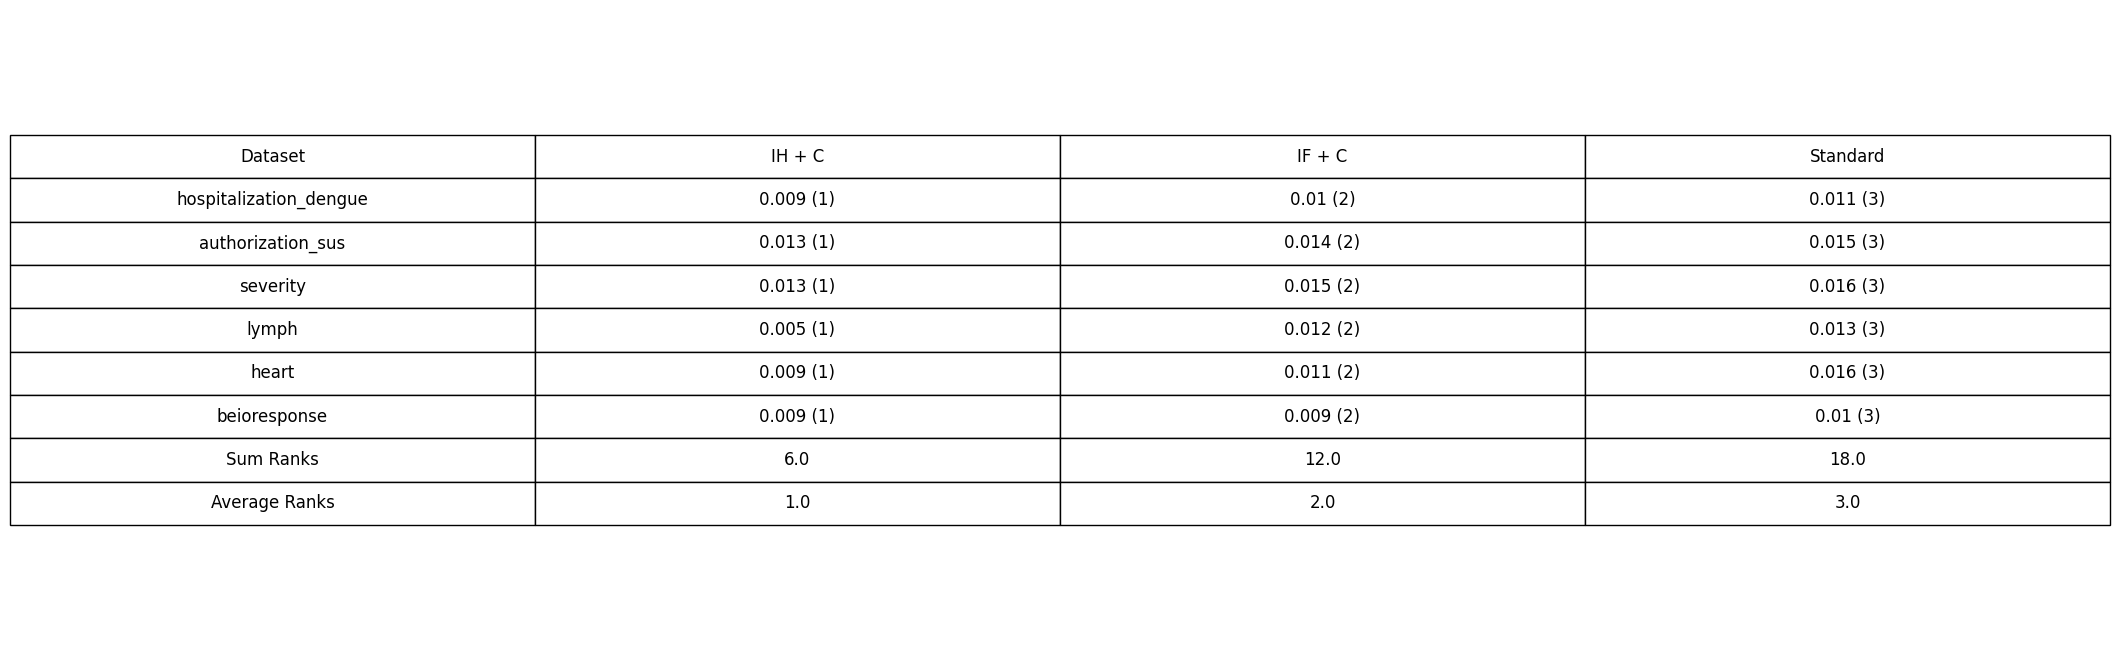

Table saved as 'table_with_rankings.png'
Friedman test statistic: 12.0, p-value = 0.002478752176666357
Algorithms: ['IH + C', 'IF + C', 'Standard']
Errors: [[0.00947 0.01    0.0106 ]
 [0.0128  0.0136  0.0148 ]
 [0.0133  0.0148  0.0155 ]
 [0.00544 0.0124  0.0131 ]
 [0.00932 0.0112  0.0157 ]
 [0.00911 0.00942 0.0101 ]]


<Figure size 1400x1200 with 0 Axes>

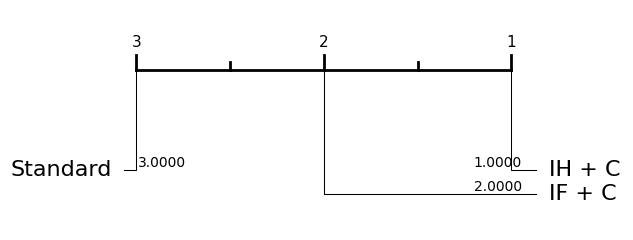

In [34]:
data_confidence = {
    'Datasets': [
      'hospitalization_dengue', 'authorization_sus', 
      'severity', 'lymph',
      'heart', 'beioresponse'
    ],
    'Algorithms': [
        'IH + C', 'IF + C', 'Standard'
    ],
    'Performance (Macro-F1)': [
        [ # hospitalization_dengue
            '0.947', '1.0', '1.06'
        ],
        [ # authorization_sus
            '1.28','1.36','1.48'
        ],
        [ # severity
            '1.33','1.48','1.55'
        ],
        [ # limphy
            '0.544', '1.24', '1.31'
        ],
        [  # heart
            '0.932','1.12','1.57'
        ],
        [ # bioresponse
            '0.911','0.942','1.01'
        ]
    ]
}

cd_graph(data_confidence, 'confidence')